# Book Genre Prediction
Welcome, this my final project for the Introduction to Deep Learning which will be based on NLP and try to replicate some of the models to evaluate which one does a better job and if we could improve on them to get a higher accuracy score.

## The Challenge
With this [dataset](https://www.kaggle.com/datasets/athu1105/book-genre-prediction?select=data.csv) provided by the Kaggle uer Atharva Inamdar the objective is to predict the genre of a book with its sinopsis as the main feature.

This is something more interesting to me since this is not only a **True** or **False** problem but we have more categories here which is relevant to NLP problems where we need to get a deeper understanding of the inputs.

I'll be using text vectorization and try to use two different models and compare them.

# The Data
## Exploratory Data Analyis
I'll start with exploring the provided data and see the dimension and features of the provided data.

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import losses

In [2]:
# Importing the Data
data = pd.read_csv('../input/book-genre-prediction/data.csv', usecols=['title', 'genre', 'summary'], dtype='str')
data.head()

,title,genre,summary
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [3]:
# Brief overview of the data how it looks
data.info

<bound method DataFrame.info of                                   title    genre  \
0                     Drowned Wednesday  fantasy   
1                         The Lost Hero  fantasy   
2             The Eyes of the Overworld  fantasy   
3                       Magic's Promise  fantasy   
4                        Taran Wanderer  fantasy   
...                                 ...      ...   
4652                            Hounded  fantasy   
4653  Charlie and the Chocolate Factory  fantasy   
4654                         Red Rising  fantasy   
4655                          Frostbite  fantasy   
4656                           Radiance  fantasy   

                                                summary  
0      Drowned Wednesday is the first Trustee among ...  
1      As the book opens, Jason awakens on a school ...  
2      Cugel is easily persuaded by the merchant Fia...  
3      The book opens with Herald-Mage Vanyel return...  
4      Taran and Gurgi have returned to Caer Dallben.

In [4]:
# Example summary of a book
example = data.sample(1, random_state=42, axis=0)
print(list(example['summary']))

[" Thomas Jerome Newton is a humanoid alien who comes to Earth seeking to construct a spaceship to ferry others from his home planet, Anthea, to Earth. Anthea is experiencing a terrible drought after many nuclear wars, and the population has dwindled to less than 300. They have hundreds of superior starships, but for not being used for over 500 years, they are unusable because of little to no fuel. They have no water, loads of food that is slowly dwindling, and feeble solar power. Like all Antheans, he is super-intelligent, but he has been selected to complete this mission for his strength, due to the harsh climate and gravity of Earth compared to the cold, small Anthea. Getting to Earth via a lifeboat, Newton first lands in the state of Kentucky but quickly becomes familiarized with the environment and aspires to become an entrepreneur. Newton uses advanced technology from his home planet to patent many inventions on Earth, and rises as the head of a technology-based conglomerate to i

In [5]:
# List of genres to be predicted
genre_list = data['genre'].unique()
print('Number of genres:', len(genre_list))
print(genre_list)

Number of genres: 10
['fantasy' 'science' 'crime' 'history' 'horror' 'thriller' 'psychology'
 'romance' 'sports' 'travel']


In [6]:
# Missing Data
data.isna().sum()

title      0
genre      0
summary    0
dtype: int64

<AxesSubplot:>

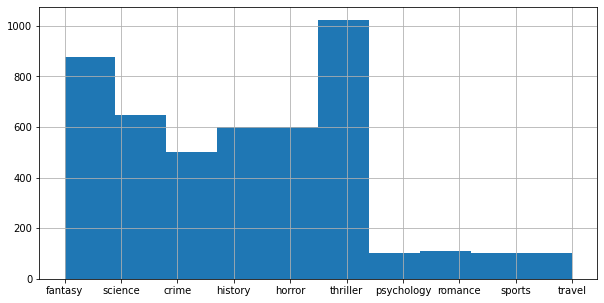

In [7]:
# Distribution of target lables
data['genre'].hist(figsize=(10,5))

<AxesSubplot:title={'center':'Summary word count'}>

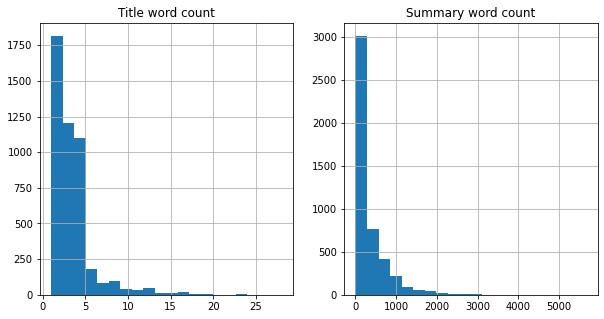

In [8]:
plt.subplots(1,2, figsize=(10,5))

plt.subplot(121)
plt.title('Title word count')
data['title'].str.split().map(len).hist(bins=20)

plt.subplot(122)
plt.title('Summary word count')
data['summary'].str.split().map(len).hist(bins=20)

In [9]:
data['title'].str.split().map(len).describe()

count    4657.000000
mean        3.477775
std         2.580572
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        28.000000
Name: title, dtype: float64

In [10]:
data['summary'].str.split().map(len).describe()

count    4657.000000
mean      359.148594
std       437.584315
min         1.000000
25%       118.000000
50%       193.000000
75%       436.000000
max      5663.000000
Name: summary, dtype: float64

### EDA Results
* We have a total of 4,657 records belonging to 10 different genres.
    * There are no missing records.
    * We see with describe the distribution of words which is important to define hyperparameters.
* The genres are not evenly distributed, we might need to have more examples from `'psychology', 'romance', 'sports', 'travel'` in order to get a better model to predict this kind of cases.
* Title and Summary word counts have some limits which will be useful for the text vectorization, for example a summary with more than 2,000 words might be an outlier we do not want to consider to avoid overfitting the model.
* **Text Cleanup**
    * A lot of the text contains periods comas and capital letters, I'll be handling this with the **Tensorflow** `TextVectorization` module in order for it to follow a standard set of rules to do this preprocessing for me. You can read more about it [**here**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to see some of the arguments that are available within the library.

## Data Preprocessing
I'll begin with the data preprocessing by separating the goal label from the raw dataset and adjusting it to split it into multiple datasets which will be used for this project.

In [11]:
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['genre'].values)

In [12]:
validation = test.sample(frac=0.5, random_state=42)
test.drop(validation.index, inplace=True)

print(f'Number of rows in training set: {len(train)}')
print(f'Number of rows in validation set: {len(validation)}')
print(f'Number of rows in test set: {len(test)}')

Number of rows in training set: 3725
Number of rows in validation set: 466
Number of rows in test set: 466


In [13]:
terms = tf.constant(train['genre'].values)
lookup = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print(f'Vocabulary: {vocab}')

2022-10-11 02:05:38.766352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 02:05:38.865882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 02:05:38.866638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 02:05:38.869865: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Vocabulary: ['[UNK]', 'thriller', 'fantasy', 'science', 'horror', 'history', 'crime', 'romance', 'travel', 'sports', 'psychology']


In [14]:
sample_label = train['genre'].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: fantasy
Label-binarized representation: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
batch_size = 64 # Batch hyperparameter
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe['genre'].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe['summary'].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [16]:
train_ds = make_dataset(train, is_train=True)
validation_ds = make_dataset(validation, is_train=False)
test_ds = make_dataset(test, is_train=False)

In [17]:
vocabulary = set()
train['summary'].str.lower().str.split().apply(vocabulary.update)
max_vocabulary = len(vocabulary)

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_vocabulary,
    ngrams = 2)
#     output_mode='tf_idf')

print(f'Number of words in vocabulary: {max_vocabulary}')

Number of words in vocabulary: 102208


In [18]:
with tf.device('/CPU:0'):
    vectorize_layer.adapt(train_ds.map(lambda text, label: text))

In [19]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()),output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          6541312   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                715       
Total params: 6,616,331
Trainable params: 6,616,331
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['categorical_accuracy'])

In [21]:
epochs = 20

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=validation_ds,
                   )

Epoch 1/20


2022-10-11 02:05:53.124554: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


59/59 [==============================] - 29s 347ms/step - loss: 2.3799 - categorical_accuracy: 0.1487 - val_loss: 2.3494 - val_categorical_accuracy: 0.1888
Epoch 2/20
59/59 [==============================] - 19s 316ms/step - loss: 2.2055 - categorical_accuracy: 0.1882 - val_loss: 2.0734 - val_categorical_accuracy: 0.2361
Epoch 3/20
59/59 [==============================] - 19s 317ms/step - loss: 2.0483 - categorical_accuracy: 0.2199 - val_loss: 2.0450 - val_categorical_accuracy: 0.2361
Epoch 4/20
59/59 [==============================] - 18s 305ms/step - loss: 2.0288 - categorical_accuracy: 0.2212 - val_loss: 2.0318 - val_categorical_accuracy: 0.2361
Epoch 5/20
59/59 [==============================] - 19s 315ms/step - loss: 1.9967 - categorical_accuracy: 0.2384 - val_loss: 1.9899 - val_categorical_accuracy: 0.2339
Epoch 6/20
59/59 [==============================] - 19s 318ms/step - loss: 1.9597 - categorical_accuracy: 0.2472 - val_loss: 2.0203 - val_categorical_accuracy: 0.2361
Epoch 7/2

In [22]:
model2 = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()),output_dim=128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11),
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         13082624  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 11)                715       
Total params: 13,206,923
Trainable params: 13,206,923
Non-trainable params: 0
__________________________________________

In [23]:
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['categorical_accuracy'])

In [24]:
epochs = 20

history2 = model2.fit(train_ds,
                    epochs=epochs,
                    validation_data=validation_ds,
                   )

Epoch 1/20
59/59 [==============================] - 27s 349ms/step - loss: 2.3809 - categorical_accuracy: 0.1901 - val_loss: 2.3432 - val_categorical_accuracy: 0.2361
Epoch 2/20
59/59 [==============================] - 19s 325ms/step - loss: 2.1778 - categorical_accuracy: 0.2193 - val_loss: 2.0618 - val_categorical_accuracy: 0.2361
Epoch 3/20
59/59 [==============================] - 19s 320ms/step - loss: 2.0417 - categorical_accuracy: 0.2183 - val_loss: 2.0336 - val_categorical_accuracy: 0.2361
Epoch 4/20
59/59 [==============================] - 19s 316ms/step - loss: 1.9903 - categorical_accuracy: 0.2631 - val_loss: 1.9401 - val_categorical_accuracy: 0.3090
Epoch 5/20
59/59 [==============================] - 19s 322ms/step - loss: 1.8845 - categorical_accuracy: 0.2913 - val_loss: 1.9079 - val_categorical_accuracy: 0.3219
Epoch 6/20
59/59 [==============================] - 19s 322ms/step - loss: 1.8072 - categorical_accuracy: 0.3216 - val_loss: 1.8579 - val_categorical_accuracy: 0.349

In [25]:
text_vectorizer = layers.TextVectorization(
    max_tokens=max_vocabulary, ngrams=2, output_mode="tf_idf"
)

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_ds.map(lambda text, label: text))

train_ds = train_ds.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_ds = validation_ds.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_ds = test_ds.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

In [26]:
def make_model():
    shallow_mlp_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model

Epoch 1/20
59/59 [==============================] - 2s 31ms/step - loss: 2.7373 - categorical_accuracy: 0.4859 - val_loss: 1.3838 - val_categorical_accuracy: 0.6588
Epoch 2/20
59/59 [==============================] - 2s 27ms/step - loss: 0.2426 - categorical_accuracy: 0.9643 - val_loss: 1.7626 - val_categorical_accuracy: 0.6352
Epoch 3/20
59/59 [==============================] - 2s 29ms/step - loss: 0.1605 - categorical_accuracy: 0.9705 - val_loss: 1.5208 - val_categorical_accuracy: 0.6588
Epoch 4/20
59/59 [==============================] - 2s 28ms/step - loss: 0.1107 - categorical_accuracy: 0.9756 - val_loss: 1.6306 - val_categorical_accuracy: 0.6695
Epoch 5/20
59/59 [==============================] - 2s 31ms/step - loss: 0.0923 - categorical_accuracy: 0.9729 - val_loss: 1.7358 - val_categorical_accuracy: 0.6545
Epoch 6/20
59/59 [==============================] - 2s 28ms/step - loss: 0.0746 - categorical_accuracy: 0.9742 - val_loss: 1.4585 - val_categorical_accuracy: 0.6974
Epoch 7/20

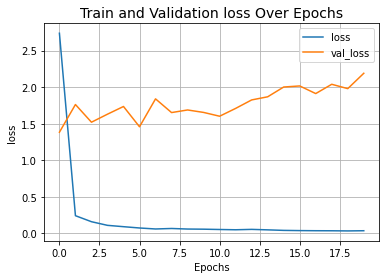

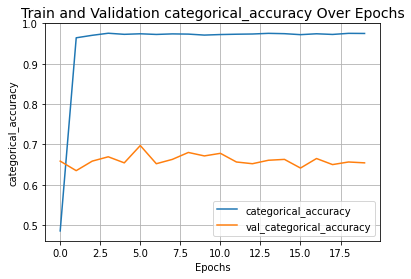

In [27]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history3 = shallow_mlp_model.fit(
    train_ds, validation_data=validation_ds, epochs=epochs
)


def plot_result(item):
    plt.plot(history3.history[item], label=item)
    plt.plot(history3.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")